In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datetime import date
import numpy as np
import mne as mne
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle


ELECTRODES_NUM = 35

today = date.today().strftime("%b-%d-%Y")
month = date.today().strftime("%B")
root_folder = f"data/{month}/{today}"
# root_folder = f"data/{month}/{today}/raw"
# root_folder = "data/December/Dec-19-2022"
# subject = '08_31_10_Itay'

In [11]:
def product(*args, repeat=1):
    # product('ABCD', 'xy') --> Ax Ay Bx By Cx Cy Dx Dy
    # product(range(2), repeat=3) --> 000 001 010 011 100 101 110 111
    pools = [tuple(pool) for pool in args] * repeat
    result = [[]]
    for pool in pools:
        result = [x+[y] for x in result for y in pool]
    for prod in result:
        yield tuple(prod)

def plot_confusion_matrix(cm, class_names,flag):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm_norm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm_norm.max() / 2.
    
    for i, j in product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        color = "white" if cm_norm[i, j] > 0.34 else "black"
        plt.text(j, i, '({:.0f}%)\n {}'.format(cm_norm[i, j]*100, cm[i,j]), horizontalalignment="center", color=color, linespacing=3, fontsize='large')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

def one_hot_encoder(labels, classes_num = 3):
    epochs_num = labels.shape[0]
    labels_onehot = np.zeros((epochs_num, classes_num))
    for i in range(epochs_num):
        labels_onehot[i, int(labels[i]-1)] = 1
    return labels_onehot

def print_confusion_matrix(model, data, true_labels_onehot, is_test = False):
    ###### Evaluation
    prediction = model.predict(data)
    y_hat = np.zeros(np.shape(true_labels_onehot))
    for i in range(np.shape(y_hat)[0]):
        y_hat[i,np.argmax(prediction[i,:])] = 1
    delta = np.sum(abs(y_hat - true_labels_onehot), axis=1)
    accuracy = len(delta[delta==0])/len(delta)*100
    if is_test:
        print(f"Accuracy: {round(accuracy, 2)}")
    
    # Calculating Confusion Matrix
    y_pred = np.argmax(y_hat, axis=1)
    y_true = np.argmax(true_labels_onehot, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    
    class_names=["Right","Left","No Movement"]
    figure = plot_confusion_matrix(cm, class_names=class_names, flag=1)

In [12]:
# Import data - reconstructed from the best ICs
# train_val_set = mne.io.read_epochs_eeglab(root_folder + '/reconstructed_from_best_train_ICs.set')
# test_set = mne.io.read_epochs_eeglab(root_folder + '/reconstructed_from_best_test_ICs.set')

# Import data - non processed data
train_val_set = mne.io.read_epochs_eeglab(root_folder + '/base_removed_train_set.set')
test_set = mne.io.read_epochs_eeglab(root_folder + '/base_removed_test_set.set')

# Import data - Igor cleaned dataset
# train_val_set = mne.io.read_epochs_eeglab(root_folder + '/igor-train_set.set')
# test_set = mne.io.read_epochs_eeglab(root_folder + '/igor-test_set.set')

# Import data - Igor RECONSTRUCTED dataset
# train_val_set = mne.io.read_epochs_eeglab(root_folder + '/igor-reconstructed_from_best_train_ICs.set')
# test_set = mne.io.read_epochs_eeglab(root_folder + '/igor-reconstructed_from_best_test_ICs.set')

# Import data - 22 subjects
# train_val_set = mne.io.read_epochs_eeglab(root_folder + '/' + subject + '/reconstructed_train.set')
# test_set = mne.io.read_epochs_eeglab(root_folder + '/' + subject + '/reconstructed_test.set')
# train_val_set = mne.io.read_epochs_eeglab(root_folder + '/' + subject + '/train_set.set')
# test_set = mne.io.read_epochs_eeglab(root_folder + '/' + subject + '/test_set.set')

# Import data - merged 22
# train_val_set = mne.io.read_epochs_eeglab(root_folder + '/train_merged.set')
# test_set = mne.io.read_epochs_eeglab(root_folder + '/test_merged.set')

# Create labels
train_val_labels = train_val_set.events[:,2]
test_labels = test_set.events[:,2]

print(train_val_labels.shape)
print(test_labels.shape)

Extracting parameters from c:\Users\alonb\OneDrive - Technion\טכניון\סמסטר ט' - אביב 2022\פרוייקט א\eeg-bss\data\January\Jan-03-2023\base_removed_train_set.set...
Not setting metadata
366 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from c:\Users\alonb\OneDrive - Technion\טכניון\סמסטר ט' - אביב 2022\פרוייקט א\eeg-bss\data\January\Jan-03-2023\base_removed_test_set.set...
Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Ready.
(366,)
(74,)


In [13]:
# Transform data
electrodes_names_grid = np.array([
    ['F5','F3','F1','Fz','F2','F4','F6'],
    ['FC5','FC3','FC1','FCz','FC2','FC4','FC6'],
    ['C5','C3','C1','Cz','C2','C4','C6'],
    ['CP5','CP3','CP1','CPz','CP2','CP4','CP6'],
    ['P5','P3','P1','Pz','P2','P4','P6']
])
ROW_NUM, COL_NUM = electrodes_names_grid.shape
TIME_SAMPLES_NUM = train_val_set.times.shape[0]
TRAIN_VAL_EPOCHS_NUM = train_val_set.selection.shape[0]
TEST_EPOCHS_NUM = test_set.selection.shape[0]

train_val_data = np.empty((ROW_NUM, COL_NUM, TRAIN_VAL_EPOCHS_NUM, TIME_SAMPLES_NUM))
test_data = np.empty((ROW_NUM, COL_NUM, TEST_EPOCHS_NUM, TIME_SAMPLES_NUM))

for i in range(ROW_NUM):
    for j in range(COL_NUM):
        channel_name = [electrodes_names_grid[i,j]]
        train_val_data[i,j,:,:] = np.squeeze(train_val_set.copy().pick_channels(channel_name).get_data())
        test_data[i,j,:,:] = np.squeeze(test_set.copy().pick_channels(channel_name).get_data())
        
train_val_data = np.moveaxis(train_val_data, 2, 0) * (10**6)
test_data = np.moveaxis(test_data, 2, 0) * (10**6)

train_val_data = np.expand_dims(train_val_data, axis=4)
test_data = np.expand_dims(test_data, axis=4)

train_val_labels_onehot = one_hot_encoder(train_val_labels)
test_labels_onehot = one_hot_encoder(test_labels)

train_val_data_shuffled, train_val_labels_onehot_shuffled = shuffle(train_val_data, train_val_labels_onehot, random_state=123)

train_data, val_data, train_labels_onehot, val_labels_onehot = train_test_split(train_val_data_shuffled, train_val_labels_onehot_shuffled, test_size=0.1, random_state=123, stratify=train_val_labels_onehot_shuffled)

print(train_data.shape)
print(train_labels_onehot.shape)
print(val_data.shape)
print(val_labels_onehot.shape)
print(test_data.shape)
print(test_labels_onehot.shape)

(329, 5, 7, 351, 1)
(329, 3)
(37, 5, 7, 351, 1)
(37, 3)
(74, 5, 7, 351, 1)
(74, 3)


In [3]:
model = keras.Sequential([
    layers.Conv3D(20, (3,3,200), padding='valid', input_shape=(5, 7, TIME_SAMPLES_NUM, 1), activation="relu"),
    layers.Conv3D(10, (2,2,20), padding='valid', activation="relu"),
    layers.MaxPooling3D((2, 2, 50), strides=(1,1,50)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(3, activation="softmax")
])

model.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 3, 5, 301, 20)     36020     
                                                                 
 conv3d_1 (Conv3D)           (None, 2, 4, 282, 10)     16010     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 1, 3, 5, 10)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 1, 3, 5, 10)      40        
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 150)               0         
                                                                 
 dense (Dense)               (None, 3)                 4

In [15]:
history = model.fit(train_data, train_labels_onehot, epochs=15, validation_data=(val_data, val_labels_onehot))

Epoch 1/15
11/11 [==============================] - 5s 356ms/step - loss: 1.1992 - accuracy: 0.4498 - val_loss: 2.1896 - val_accuracy: 0.5676
Epoch 2/15
11/11 [==============================] - 3s 288ms/step - loss: 0.7230 - accuracy: 0.7052 - val_loss: 1.6384 - val_accuracy: 0.5135
Epoch 3/15
11/11 [==============================] - 3s 291ms/step - loss: 0.5551 - accuracy: 0.8055 - val_loss: 1.4083 - val_accuracy: 0.5676
Epoch 4/15
11/11 [==============================] - 3s 291ms/step - loss: 0.4367 - accuracy: 0.8723 - val_loss: 0.8626 - val_accuracy: 0.7297
Epoch 5/15
11/11 [==============================] - 3s 283ms/step - loss: 0.3401 - accuracy: 0.9179 - val_loss: 0.8138 - val_accuracy: 0.7027
Epoch 6/15
11/11 [==============================] - 3s 288ms/step - loss: 0.2568 - accuracy: 0.9635 - val_loss: 0.8461 - val_accuracy: 0.6757
Epoch 7/15
11/11 [==============================] - 3s 291ms/step - loss: 0.2118 - accuracy: 0.9696 - val_loss: 0.8320 - val_accuracy: 0.7027
Epoch 

Max val accuracy: 72.97
2/2 [==============================] - 0s 9ms/step


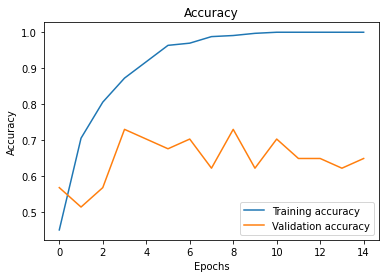

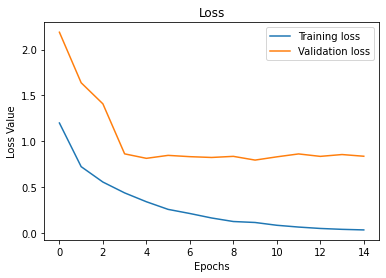

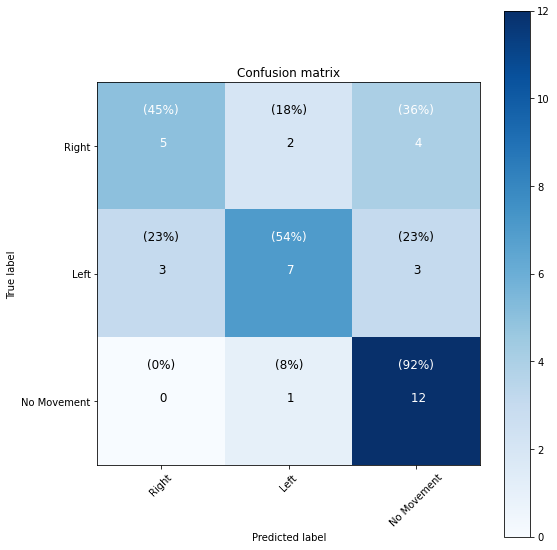

In [16]:
# Plot Accuracy graph (train set and val set)
metrics_df = pd.DataFrame(history.history)
ax = metrics_df[["accuracy", "val_accuracy"]].plot(title="Accuracy");
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy")
ax.legend(["Training accuracy", "Validation accuracy"]);

# Plot Loss graph (train set and val set)
axe = metrics_df[["loss", "val_loss"]].plot(title="Loss");
axe.set_xlabel("Epochs")
axe.set_ylabel("Loss Value")
axe.set_title("Loss")
axe.legend(["Training loss", "Validation loss"]);

print(f"Max val accuracy: {round(metrics_df.val_accuracy.max() * 100, 2)}")
print_confusion_matrix(model, val_data, val_labels_onehot)

3/3 [==============================] - 0s 21ms/step
Accuracy: 16.22


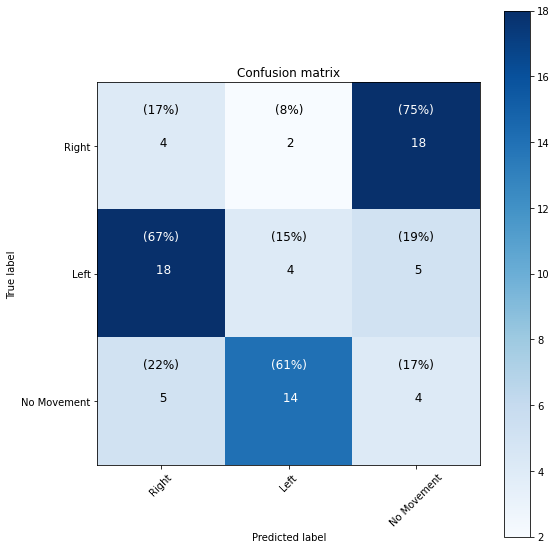

In [17]:
print_confusion_matrix(model, test_data, test_labels_onehot, is_test = True)